In [58]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt

import folium

import warnings
warnings.filterwarnings('ignore')

In [85]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
response.status_code

200

In [86]:
soup = BeautifulSoup(response.text,'html.parser')

d = {'Postal_code':[],'Borough':[]}

table = soup.find_all('table',{'rules':'all'})
for record in table[0].find_all('tr'):
    for i in record.find_all('td'):
        if i.find_all(['a','span'])[0].text == 'Not assigned':
            continue
        d['Postal_code'].append(i.find_all('b')[0].text)
        d['Borough'].append(i.find_all(['a','span'])[0].text)
df = pd.DataFrame(d)
df.head()

,Postal_code,Borough
0,M3A,North York(Parkwoods)
1,M4A,North York(Victoria Village)
2,M5A,Downtown Toronto(Regent Park / Harbourfront)
3,M6A,North York(Lawrence Manor / Lawrence Heights)
4,M7A,Queen's Park(Ontario Provincial Government)


In [87]:
import re
re.search("(?<=\().*(?=\))",'Downtown Toronto(Regent Park / Harbourfront)').group().split('/')[0].strip()

'Regent Park'

In [88]:
df['Neighborhood'] = df.Borough.apply(lambda x: re.search("(?<=\().*(?=\))",x).group().split('/')[0].strip())
df['Borough'] = df.Borough.str.split('(',expand=True)[0]

df['latitude'] = None
df['longitude'] = None

df.head()

,Postal_code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,None,None
1,M4A,North York,Victoria Village,None,None
2,M5A,Downtown Toronto,Regent Park,None,None
3,M6A,North York,Lawrence Manor,None,None
4,M7A,Queen's Park,Ontario Provincial Government,None,None


In [89]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent="my-pred")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)


for i in range(len(df)):
    address = df.iloc[i,2]+' , Toronto, Ontario'
    location = geocode(address,timeout=3) #timeout=3, dealing with timeout error
    try:
        latitude = location.latitude
        longitude = location.longitude
        df.iloc[i,3] = latitude
        df.iloc[i,4] = longitude
    except:
        print(df.iloc[i,2])
        df.iloc[i,3] = 'NA'
        df.iloc[i,4] = 'NA'

Ontario Provincial Government
Garden District, Ryerson
Don Mills)South(Flemingdon Park
Caledonia-Fairbanks
Central Bay Street
Harbourfront East
Downsview)East  (CFB Toronto
The Danforth West
Davisville North
Enclave of L4W
Enclave of M5E
Enclave of M4L


In [90]:
missing_labeled = df.Neighborhood.str.split('(', expand=True).iloc[:,1].apply(lambda x: 'NA' if None else x).dropna()
missing_labeled

13    Flemingdon Park
40        CFB Toronto
Name: 1, dtype: object

In [91]:
df.iloc[missing_labeled.index,2] = missing_labeled
df.iloc[missing_labeled.index,2]

13    Flemingdon Park
40        CFB Toronto
Name: Neighborhood, dtype: object

In [92]:
l = [#'Ontario Provincial Government',  #outlier
     'Garden District, Ryerson',
     'Flemingdon Park',
     #'Central Bay Street',    #outlier
     'Harbourfront East',
     ]
d = {
    'Caledonia-Fairbanks':[43.6899,79.4552],
     'CFB Toronto':[43.6544,79.3807],
    'The Danforth West':[43.679557,-79.352188],
     'Davisville North':[43.4212,79.238],
}

for location in l:
    a = geocode(location)
    # df[df['Neighborhood'] == location].iloc[0,3] = a.latitude
    # df[df['Neighborhood'] == location].iloc[0,4] = a.longitude
    
    row = df[df['Neighborhood'] == location].index
    df.at[row, 'latitude'] = a.latitude
    df.at[row, 'longitude'] = a.longitude

for location in d:
    # df[df['Neighborhood'] == location].iloc[0,3] = d[location][0]
    # df[df['Neighborhood'] == location].iloc[0,4] = d[location][1]

    row = df[df['Neighborhood'] == location].index
    df.at[row, 'latitude'] = d[location][0]
    df.at[row, 'longitude'] = d[location][1]

In [93]:
df[df['latitude'] == 'NA']

,Postal_code,Borough,Neighborhood,latitude,longitude
4,M7A,Queen's Park,Ontario Provincial Government,NA,NA
24,M5G,Downtown Toronto,Central Bay Street,NA,NA
76,M7R,MississaugaCanada Post Gateway Processing Centre,Enclave of L4W,NA,NA
92,M5W,Downtown TorontoStn A PO Boxes25 The Esplanade,Enclave of M5E,NA,NA
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,NA,NA


In [95]:
df = df[df.latitude != 'NA']

df.shape

(98, 5)

In [99]:
geocode("Toronto, Canada")

Location(Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada, (43.6534817, -79.3839347, 0.0))

In [96]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='stamen toner')

for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
# map_toronto.save('map.html')
map_toronto

In [97]:
df.dtypes

Postal_code     object
Borough         object
Neighborhood    object
latitude        object
longitude       object
dtype: object

In [98]:
df['latitude'] = df['latitude'].astype('float')
df['longitude'] = df['longitude'].astype('float')

df.dtypes

Postal_code      object
Borough          object
Neighborhood     object
latitude        float64
longitude       float64
dtype: object

## Use Foursquare API for Data Extraction

In [122]:
CLIENT_ID = '' 
CLIENT_SECRET = ''
VERSION = '20220716'

# Top 100 venues that are within a radius of 2000 meter
radius = 2000
LIMIT = 100

places = []

for lat, long, neighborhood in zip(df['latitude'], df['longitude'], df['Neighborhood']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    resultset = requests.get(url).json()["response"]['groups'][0]['items']
    
    for location in resultset:
        places.append((
            neighborhood,
            lat, 
            long, 
            location['venue']['name'], 
            location['venue']['location']['lat'], 
            location['venue']['location']['lng'],  
            location['venue']['categories'][0]['name']))
places_df = pd.DataFrame(places,columns=['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory'])
places_df.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Parkwoods,43.75772,-79.315941,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.75772,-79.315941,LCBO,43.757774,-79.314257,Liquor Store
2,Parkwoods,43.75772,-79.315941,Kostas Meat Market,43.760605,-79.301830,Greek Restaurant
3,Parkwoods,43.75772,-79.315941,Dollarama,43.758135,-79.310672,Discount Store
4,Parkwoods,43.75772,-79.315941,Tim Hortons,43.760668,-79.326368,Café


In [124]:
places_df.shape

(7691, 7)

In [126]:
places_df.to_csv('venues_explore_data.csv')

In [128]:
places_df.groupby(["Neighborhood"]).count() #Number of venues returned for each neighbor remember max limit was 100

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Agincourt,100,100,100,100,100,100
Alderwood,100,100,100,100,100,100
Bathurst Manor,69,69,69,69,69,69
Bayview Village,68,68,68,68,68,68
Bedford Park,83,83,83,83,83,83
...,...,...,...,...,...,...
Willowdale,300,300,300,300,300,300
Woburn,61,61,61,61,61,61
Woodbine Heights,95,95,95,95,95,95


In [129]:
print('There are {} unique categories.'.format(len(places_df['VenueCategory'].unique())))  

There are 327 unique categories.


#### One-hot encoding

In [134]:
# In every line, one the venue category is 1 and all other records are 0
pd.get_dummies(places_df[['VenueCategory']], prefix="", prefix_sep="").head()

,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,...,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
onehot = pd.get_dummies(places_df[['VenueCategory']], prefix="", prefix_sep="")

onehot['Neighborhoods'] = places_df['Neighborhood'] 

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head()

(7691, 328)


,Neighborhoods,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,...,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
# group rows by neighborhood taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby(["Neighborhoods"]).mean().reset_index()
print(grouped.shape)
grouped.head()

(89, 328)


,Neighborhoods,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,...,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0
1,Alderwood,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor,0.0,0.0,0.0,0.0,0.014493,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.014706,0.0,0.0,0.0,0.0,0.0
4,Bedford Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.012048,0.0,0.0,0.0,0.0,0.0


## DataFrame for Shopping Mall data only

In [139]:
df_mall = grouped[["Neighborhoods","Shopping Mall"]]
print(df_mall.shape)
df_mall.head()

(89, 2)


,Neighborhoods,Shopping Mall
0,Agincourt,0.010000
1,Alderwood,0.010000
2,Bathurst Manor,0.014493
3,Bayview Village,0.014706
4,Bedford Park,0.000000


# Clustering Data


### A. KMeans Clustering
1. Feature Scaling

2. Find number of clusters
    - Elbow Method
    - Silhouette Coefficient

---

- Since KMeans Clustering is distance-based ML Algorithm, feature scaling is required for accurate result. 

- We can perform **Standardization** if the data is normally distributed using `StandardScaler` else we can perform `MinMaxScaler`. 

- Checking the Normality of data - https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93


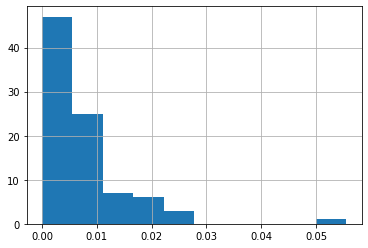

In [223]:
df_mall['Shopping Mall'].hist()  #Not normally distributed

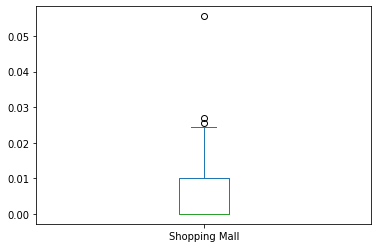

In [224]:
df_mall['Shopping Mall'].plot(kind = 'box')

In [225]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

data = MinMaxScaler().fit_transform(df_mall['Shopping Mall'].to_numpy().reshape(-1,1))
data[:5]

array([[0.18      ],
       [0.18      ],
       [0.26086957],
       [0.26470588],
       [0.        ]])

### Find Number of clusters
1. Elbow Method

In [226]:
kwargs = {
     "init": "k-means++",
     "n_init": 10,
     "max_iter": 200,
     "random_state": 29,
 }

SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kwargs)
    kmeans.fit(data)
    SSE.append(kmeans.inertia_)

In [227]:
SSE

[2.347649602159242,
 0.8731489200116669,
 0.30890751793351723,
 0.06695509372965404,
 0.019361817386909893,
 0.00675166858671699,
 0.0031314684763027994,
 0.0021790376943032893,
 0.0013051667524968404,
 0.0008455075781704073]

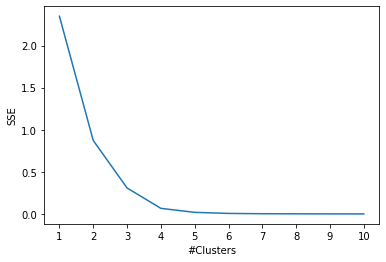

In [228]:
plt.plot(range(1, 11), SSE)
plt.xticks(range(1, 11))
plt.xlabel("#Clusters")
plt.ylabel("SSE")
plt.show()

In [229]:
# !pip install kneed
from kneed import KneeLocator

KneeLocator(range(1, 11), SSE, curve="convex", direction="decreasing").elbow

3

2. Silhouette Coefficient

In [230]:
from sklearn.metrics import silhouette_score

coeff = []

for k in range(2, 11):  #at least 2 clusters are must for silhouette coeff. 
    kmeans = KMeans(n_clusters=k, **kwargs)
    kmeans.fit(df_mall['Shopping Mall'].to_numpy().reshape(-1,1))
    score = silhouette_score(df_mall['Shopping Mall'].to_numpy().reshape(-1,1), kmeans.labels_)
    coeff.append(score)

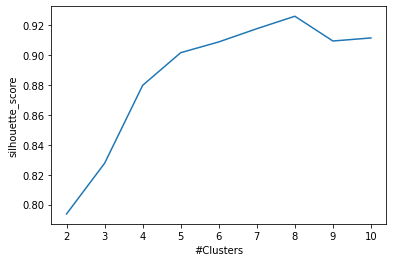

In [231]:
plt.plot(range(2, 11), coeff)
plt.xticks(range(2, 11))
plt.xlabel("#Clusters")
plt.ylabel("silhouette_score")
plt.show()

In [232]:
kmeans = KMeans(n_clusters=3,**kwargs)
kmeans = kmeans.fit(df_mall['Shopping Mall'].to_numpy().reshape(-1,1))
kmeans.labels_[:10]

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int32)

In [233]:
df_mall["Kmeans_Cluster_Label"] = kmeans.labels_
df_mall.head()

,Neighborhood,Shopping Mall,Kmeans_Cluster_Label
0,Agincourt,0.010000,1
1,Alderwood,0.010000,1
2,Bathurst Manor,0.014493,1
3,Bayview Village,0.014706,1
4,Bedford Park,0.000000,0


In [234]:
df_mall.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
df_cluster = df_mall.join(df.set_index("Neighborhood"), on="Neighborhood")
df_cluster.head()

,Neighborhood,Shopping Mall,Kmeans_Cluster_Label,Postal_code,Borough,latitude,longitude
0,Agincourt,0.010000,1,M1S,Scarborough,43.785353,-79.278549
1,Alderwood,0.010000,1,M8W,Etobicoke,43.601717,-79.545232
2,Bathurst Manor,0.014493,1,M3H,North York,43.763893,-79.456367
3,Bayview Village,0.014706,1,M2K,North York,43.769197,-79.376662
4,Bedford Park,0.000000,0,M5M,North York,43.737388,-79.410925


In [238]:
map = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='stamen toner')

# color scheme
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['latitude'], df_cluster['longitude'], df_cluster['Neighborhood'], df_cluster['Kmeans_Cluster_Label']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map)
map.save('cluster.html')
map

#### Cluster 0

In [239]:
df_cluster.loc[df_cluster['Kmeans_Cluster_Label'] == 0]

,Neighborhood,Shopping Mall,Kmeans_Cluster_Label,Postal_code,Borough,latitude,longitude
45,Little Portugal,0.0,0,M6J,West Toronto,43.647413,-79.431116
30,Guildwood,0.0,0,M1E,Scarborough,43.755225,-79.198229
31,Harbourfront East,0.0,0,M5J,Downtown Toronto,43.644510,-79.374260
32,High Park,0.0,0,M6P,West Toronto,43.653867,-79.466864
33,Hillcrest Village,0.0,0,M2H,North York,43.681695,-79.425712
34,Humber Summit,0.0,0,M9L,North York,43.760078,-79.571760
36,Humewood-Cedarvale,0.0,0,M6C,York,43.688322,-79.428080
37,India Bazaar,0.0,0,M4L,East Toronto,43.672223,-79.323503
38,Islington Avenue,0.0,0,M9A,Etobicoke,43.724891,-79.559655
39,Kennedy Park,0.0,0,M1K,Scarborough,43.724878,-79.253969


#### Cluster 1

In [240]:
df_cluster.loc[df_cluster['Kmeans_Cluster_Label'] == 1]

,Neighborhood,Shopping Mall,Kmeans_Cluster_Label,Postal_code,Borough,latitude,longitude
84,Willowdale,0.010000,1,M2N,North York,43.761510,-79.410923
84,Willowdale,0.010000,1,M2R,North York,43.761510,-79.410923
84,Willowdale,0.010000,1,M2M,North York,43.761510,-79.410923
72,The Danforth East,0.011236,1,M4J,East YorkEast Toronto,43.701146,-79.333782
82,Weston,0.016129,1,M9N,York,43.700161,-79.516247
66,St. James Town,0.010000,1,M5C,Downtown Toronto,43.669403,-79.372704
68,Studio District,0.010000,1,M4M,East Toronto,43.649210,-79.388026
80,West Deane Park,0.027027,1,M9B,Etobicoke,43.663199,-79.568568
70,The Annex,0.010000,1,M5R,Central Toronto,43.670338,-79.407117
78,Upper Rouge,0.018868,1,M1X,Scarborough,43.809343,-79.187571


#### Cluster 2

In [241]:
df_cluster.loc[df_cluster['Kmeans_Cluster_Label'] == 2]

,Neighborhood,Shopping Mall,Kmeans_Cluster_Label,Postal_code,Borough,latitude,longitude
67,Steeles West,0.055556,2,M1W,Scarborough,43.753736,-79.621818


###Quick Result


*   Cluster 1 has medium level of competition.
*   Cluster 0 has least competition with no present mall situated.
*   Cluster 2 has highest level of competition.

